# SETUP

In [443]:
import pandas as pd
import numpy as np
import pycountry as pyc
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor



# IMPORT CSV

In [444]:
df_billet = pd.read_csv('billets.csv',sep = ';', encoding='latin1') 


# Exploration des données

### Billet

In [445]:
df_billet.shape[0]

1500

In [446]:
df_billet.head()


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [447]:
df_billet.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [448]:
df_billet.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [449]:
df_billet.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [450]:
df_billet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


### Pairplot

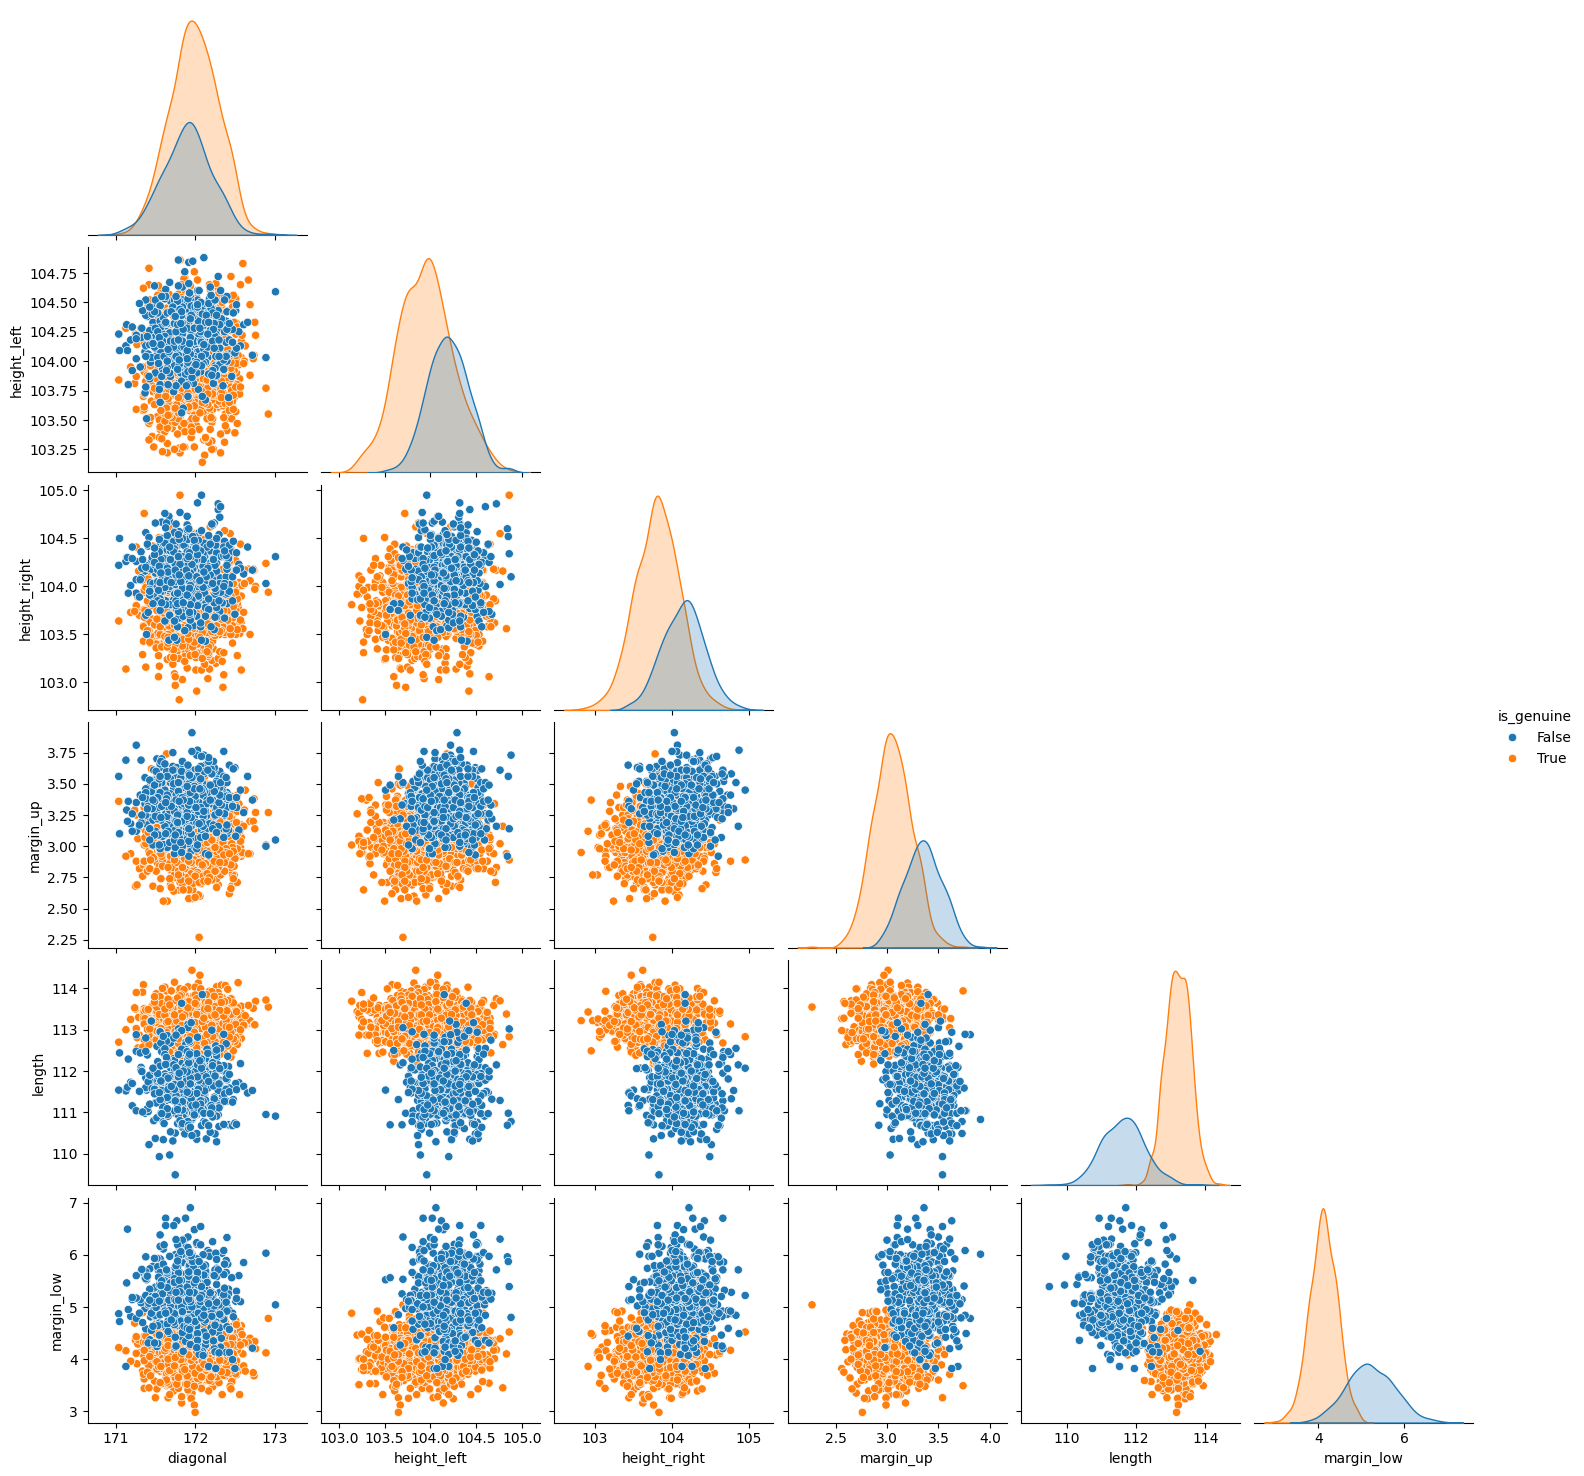

In [451]:
# Pairplot :
# Le pairplot est une étape cruciale pour l'exploration visuelle des données. Cette fonction génère une grille de graphiques qui permet de comprendre les relations entre toutes les variables en une seule visualisation
# Comprendre les distribution :
# Sur la diagonale de la grille, le pairplot affiche la distribution de chaque variable (grâce à diag_kind="kde"). On peut ainsi voir si les variables suivent une distribution normale ou si elles sont asymétriques.
# Détecter des groupes : 
# L'option hue="is_genuine" est très puissante. Elle colorie les points en fonction de l'authenticité (is_genuine). Cela  permet de voir visuellement si les billets contrefaits et les billets authentiques se regroupent dans des zones distinctes. C'est un excellent moyen de vérifier si les variables sont de bons prédicteurs pour la variable is_genuine.
# Identifier des données aberrantes : 
# Un pairplot peut également aider à repérer des valeurs extrêmes ou des erreurs de saisie qui apparaissent comme des points isolés loin du reste du nuage de données.
variable = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length', 'margin_low']
sns.pairplot(df_billet,
             vars=variable,
             hue="is_genuine",   # couleur selon authenticité
             diag_kind="kde",    # distribution lissée en diagonale
             corner=True)        # évite les doublons de graphiques
plt.show()

In [452]:
# Margin low et length et à moindre mesure margin up ont une forte capacité discriminante entre les faux et les vrais billets. Les autres sont moins discriminante mais en combinaisons elles aident quand meme.

### Colinéarité des variables

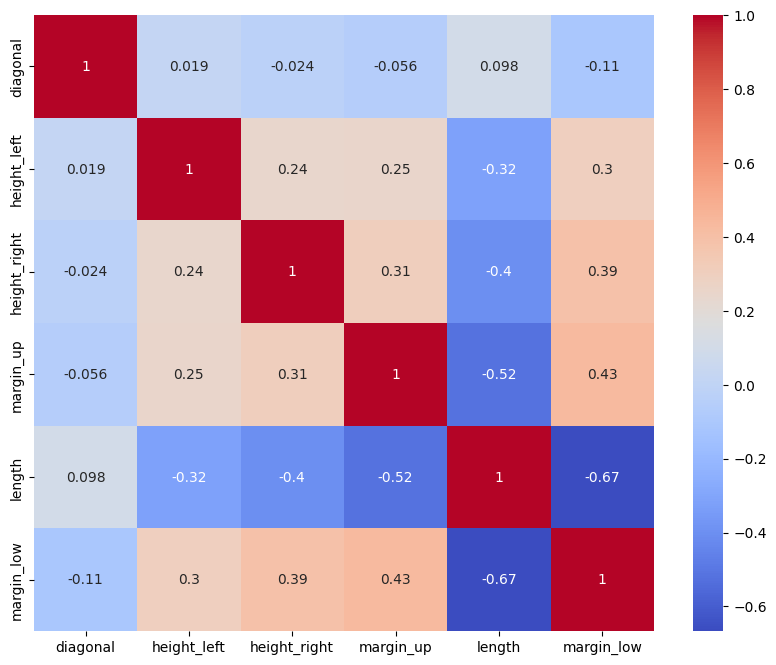

In [453]:
# Colinéarité des variables :Matrice de corrélation

X_known = df_billet[variable]
plt.figure(figsize=(10,8))
sns.heatmap(X_known.corr(), annot=True, cmap='coolwarm')
plt.show()

In [454]:
# Pas de colinéarité entre les features --> coefficient stable

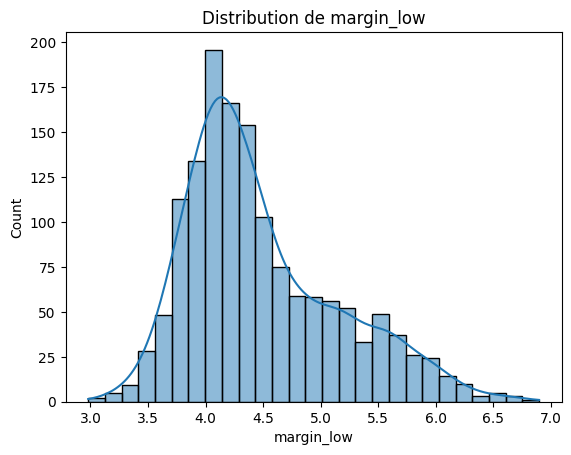

In [455]:
# Vérifier la distribution de margin_low
sns.histplot(df_billet['margin_low'].dropna(), kde=True)
plt.title("Distribution de margin_low")
plt.show()

In [456]:
# diagonal → Pas de relation linéaire claire (mauvais prédicteur).
# height_left → Faible tendance croissante (relation faible).
# height_right → Relation croissante assez nette (bon prédicteur).
# margin_up → Relation croissante claire (très bon prédicteur).
# length → Relation négative claire ( très bon prédicteur)

# Imputation de valeurs manquantes : Régression linéaire

## Préparation

In [457]:
# régression linéaire multiple car on souhaite determiner margin low à partir de toutes les autres variables (sauf is_genuine)

In [458]:
## Combler les 37 valeurs manquantes de la colonne 'margin_low'
# Création d'une nouvelle colonne pour marquer les lignes avec des valeurs 'margin_low' manquantes
df_billet['margin_low_was_missing'] = df_billet['margin_low'].isna()

# Sépare le DataFrame en deux parties
# Le DataFrame 'known' contient toutes les lignes où 'margin_low' n'est pas nul
known = df_billet[df_billet['margin_low'].notna()].copy()

# Le DataFrame 'missing' contient toutes les lignes où 'margin_low' est nul
missing = df_billet[df_billet['margin_low'].isna()].copy()

In [459]:

# features prédictrices
features = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']


X_known = known[features]
y_known = known['margin_low']
X_missing = missing[features]

## Entrainement & Performance du modèle

In [460]:
# Split train / Test
X_train, X_test, y_train, y_test = train_test_split(
    X_known, y_known, test_size=0.20, random_state=42
)

In [461]:
pipe = Pipeline([
    ('scaler', StandardScaler()),        # normaliser pour stabilité en utilisant l'écart type (autre méthode : RobustScaler qui utilise Q1 et Q3 et permet d'éviter les outliers)
    ('reg', LinearRegression())
])

# entraînement
pipe.fit(X_train, y_train)

# prédictions
y_pred_test = pipe.predict(X_test)

# metrics
rmse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
print(f"Test RMSE={rmse_test:.3f}, MAE={mae_test:.3f}, R2={r2:.3f}")
print("Ecart-type de margin_low =", y_known.std())
print("Min =", y_known.min(), "Max =", y_known.max())

Test RMSE=0.191, MAE=0.335, R2=0.546
Ecart-type de margin_low = 0.663812624177339
Min = 2.98 Max = 6.9


Interprétation :
R2 = 0.546 : Ce score est modéré. Il signifie que les variables choisies (comme la diagonale, la hauteur, etc.) expliquent un peu plus de la moitié de la variation de margin_low. Cela montre que le modèle est utile, mais il y a d'autres facteurs non inclus dans l'analyse qui influencent margin_low.

RMSE = 0.191 et MAE = 0.335 : Ces deux métriques mesurent l'erreur de prédiction. Elles sont dans une fourchette raisonnable par rapport à la plage de valeurs de margin_low, qui va de 2,98 à 6,9. L'écart-type de margin_low est de 0.664, donc le modèle a une erreur de prédiction moyenne d'environ 0,335, ce qui est acceptable.

Comparaison des erreurs : La RMSE (erreur quadratique moyenne) est plus grande que la MAE (erreur absolue moyenne), ce qui est normal. La RMSE pénalise davantage les erreurs importantes, donc cet écart suggère qu'il y a quelques prédictions pour lesquelles le modèle a commis une plus grande erreur.

Conclusion
Globalement, le modèle de régression est valide et utile pour imputer les valeurs manquantes. Le R2 de 0.546 est un bon indicateur que la régression linéaire est une approche pertinente pour le problème. Les résultats montrent que les caractéristiques physiques des billets (longueur, hauteur, etc.) sont bien liées à la margin_low.

## Test Homoscédasticité et normalité des résidus

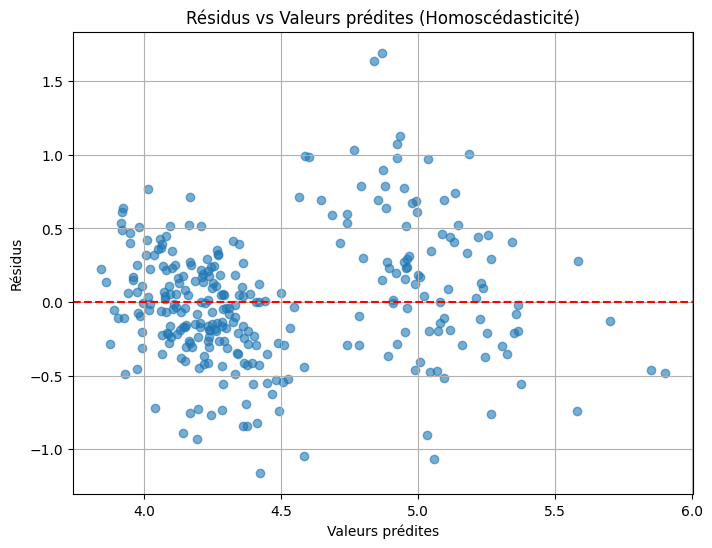

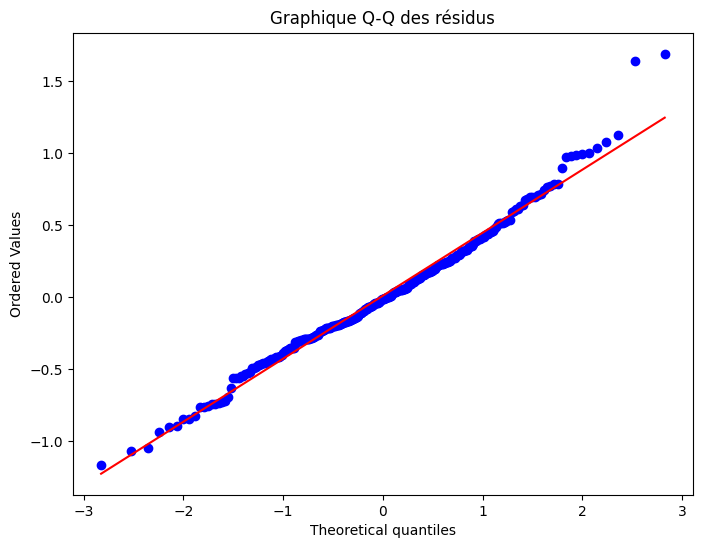

In [462]:
# Calcul des résidus sur l'ensemble de test
residus = y_test - y_pred_test

# 1. Vérification de l'homoscédasticité
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_test, residus, alpha=0.6)
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Résidus vs Valeurs prédites (Homoscédasticité)")
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()

# 2. Vérification de la normalité des résidus
import scipy.stats as stats
plt.figure(figsize=(8, 6))
stats.probplot(residus, dist="norm", plot=plt)
plt.title("Graphique Q-Q des résidus")
plt.show()

1. Résidus vs Valeurs prédites (homoscédasticité)

Les résidus semblent centrés autour de 0 (bonne chose).

La dispersion est relativement constante pour les différentes valeurs prédites.

On observe peut-être un léger effet de regroupement (deux « nuages »), mais pas de cône ou éventail qui indiquerait une hétéroscédasticité.

Conclusion : l’hypothèse d’homoscédasticité est respectée.   


2. Q-Q Plot (normalité des résidus)

Les points suivent bien la ligne rouge → les résidus sont proches d’une distribution normale.

Seuls les extrêmes (queues de distribution) s’écartent un peu de la droite → pas parfait, mais acceptable.

 Conclusion : l’hypothèse de normalité est globalement respectée.

In [463]:
 from scipy.stats import shapiro

stat, p_value = shapiro(residus)
print("Test de Shapiro-Wilk")
print("Statistique :", stat)
print("p-value :", p_value)

if p_value > 0.05:
    print("✅ On ne rejette pas H0 : les résidus suivent une distribution normale")
else:
    print("❌ On rejette H0 : les résidus ne suivent pas une distribution normale")

Test de Shapiro-Wilk
Statistique : 0.9850901433257548
p-value : 0.0038966834213471423
❌ On rejette H0 : les résidus ne suivent pas une distribution normale


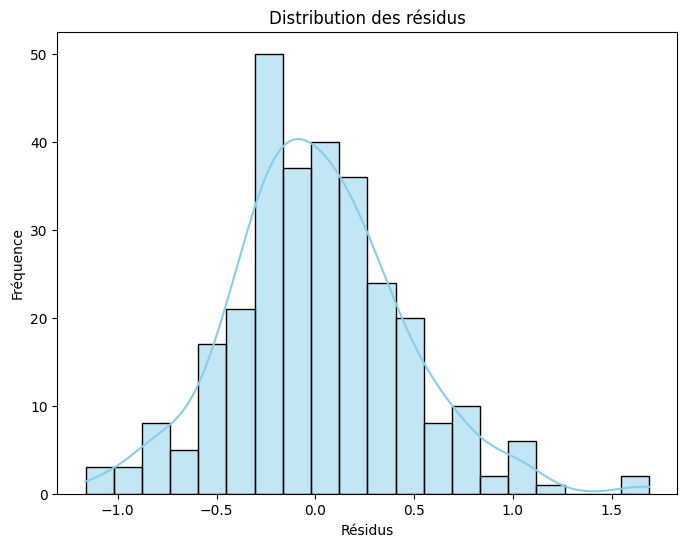

In [464]:
# Distribution des résidus :
plt.figure(figsize=(8,6))
sns.histplot(residus, kde=True, bins=20, color="skyblue")
plt.title("Distribution des résidus")
plt.xlabel("Résidus")
plt.ylabel("Fréquence")
plt.show()

Visuellement : les résidus semblent proches d’une distribution normale (en forme de cloche), donc l’hypothèse de normalité n’est pas complètement aberrante.
Statistiquement : le test de Shapiro étant très sensible (surtout avec beaucoup de données), il détecte des écarts → normalité rejetée.
En pratique : dans beaucoup de cas réels, on accepte une approximation de la normalité si :
- les résidus sont symétriques,
- centrés autour de zéro,
- sans schéma particulier.

Le test de Shapiro rejette la normalité stricte, mais la distribution des résidus reste visuellement proche d’une loi normale, ce qui est généralement acceptable en pratique pour un modèle de régression.

In [465]:
# RMSE : Root Mean Squared Error --> Racine carrée de l'erreur quadratique moyenne, mesure la différence entre les valeurs prédites et les valeurs réelles. 0,191  = très bon
# MAE : Mean Absolute Error --> Moyenne des valeurs absolues des erreurs, mesure l'écart moyen sans donner plus de poids aux grosses erreurs. (+ robuste aux outliers) 0,335 = correct
# R2 : 54,6% de la variation de margin_low est expliquée par le modèle --> correct

## Prédiction sur le DF

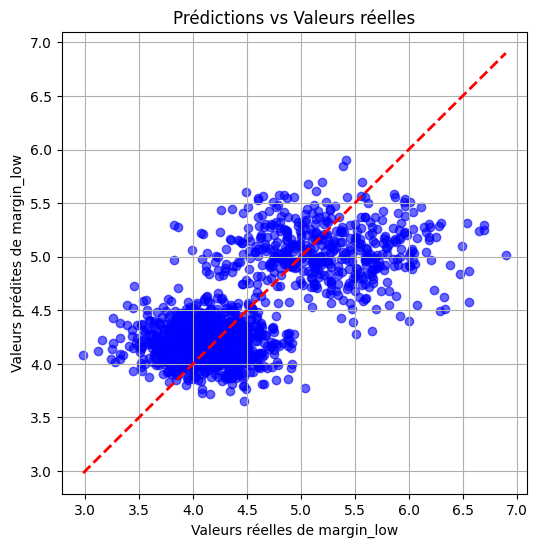

In [466]:
# Prédictions sur l'ensemble complet
y_pred_all = pipe.predict(X_known)

plt.figure(figsize=(6,6))
plt.scatter(y_known, y_pred_all, color='blue', alpha=0.6)
plt.plot([y_known.min(), y_known.max()],
         [y_known.min(), y_known.max()],
         'r--', lw=2)  # ligne y=x pour référence
plt.xlabel("Valeurs réelles de margin_low")
plt.ylabel("Valeurs prédites de margin_low")
plt.title("Prédictions vs Valeurs réelles")
plt.grid(True)
plt.show()

In [467]:
lr_model = pipe.named_steps['reg']
print("Intercept (b):", lr_model.intercept_)
print("Coefficients (a):", lr_model.coef_)

Intercept (b): 4.484786324786321
Coefficients (a): [-0.02607413  0.0465088   0.08514659  0.06831143 -0.34900989]


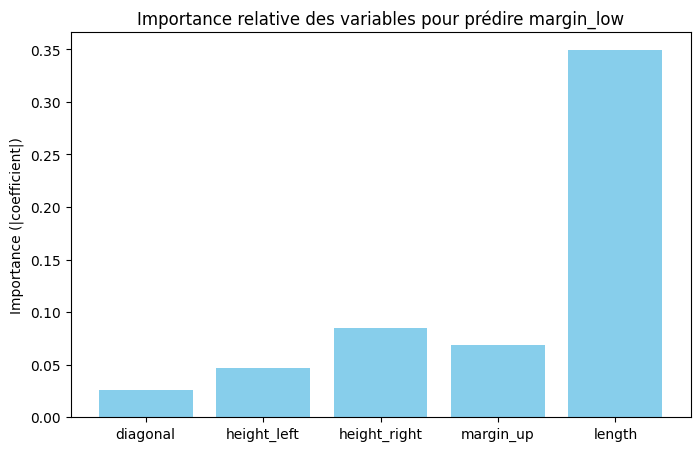

In [468]:
# Interprétation des coef
# diagonal	-0.026	Si diagonal augmente de 1 unité, margin_low diminue en moyenne de 0.026 unité, toutes choses égales par ailleurs.
# height_left	0.047	Si height_left augmente de 1 unité, margin_low augmente de 0.047 unité.
# height_right	0.085	Si height_right augmente de 1 unité, margin_low augmente de 0.085 unité.
# margin_up	0.068	Si margin_up augmente de 1 unité, margin_low augmente de 0.068 unité.
# length	-0.349	Si length augmente de 1 unité, margin_low diminue de 0.349 unité. C’est le coefficient le plus impactant ici.

# Calcul l'importance relative (valeurs absolues)
coefficients = lr_model.coef_
features = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']
importance = np.abs(coefficients)

# Trace le graphique

plt.figure(figsize=(8,5))
plt.bar(features, importance, color='skyblue')
plt.ylabel("Importance (|coefficient|)")
plt.title("Importance relative des variables pour prédire margin_low")
plt.show()

In [469]:
# Prédiction des valeurs manquantes
# Utilisation du modèle entraîné pour prédire la 'margin_low' pour les lignes manquantes
y_pred_missing = pipe.predict(X_missing)

# Remplissage de la colonne 'margin_low' dans le DataFrame 'missing'
missing.loc[:, 'margin_low'] = y_pred_missing

# Concaténe les DataFrames 'known' et 'missing'
df_billet_clean = pd.concat([known, missing], axis=0)

# Vérifie qu'il n'y a plus de valeurs manquantes
print("Vérification des valeurs manquantes dans le DataFrame final :")
print(df_billet_clean.isnull().sum())

Vérification des valeurs manquantes dans le DataFrame final :
is_genuine                0
diagonal                  0
height_left               0
height_right              0
margin_low                0
margin_up                 0
length                    0
margin_low_was_missing    0
dtype: int64


In [470]:
df_billet_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, 0 to 1438
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   is_genuine              1500 non-null   bool   
 1   diagonal                1500 non-null   float64
 2   height_left             1500 non-null   float64
 3   height_right            1500 non-null   float64
 4   margin_low              1500 non-null   float64
 5   margin_up               1500 non-null   float64
 6   length                  1500 non-null   float64
 7   margin_low_was_missing  1500 non-null   bool   
dtypes: bool(2), float64(6)
memory usage: 85.0 KB


In [471]:
df_billet_clean.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,margin_low_was_missing
0,True,171.81,104.86,104.95,4.52,2.89,112.83,False
1,True,171.46,103.36,103.66,3.77,2.99,113.09,False
2,True,172.69,104.48,103.50,4.40,2.94,113.16,False
3,True,171.36,103.91,103.94,3.62,3.01,113.51,False
4,True,171.73,104.28,103.46,4.04,3.48,112.54,False


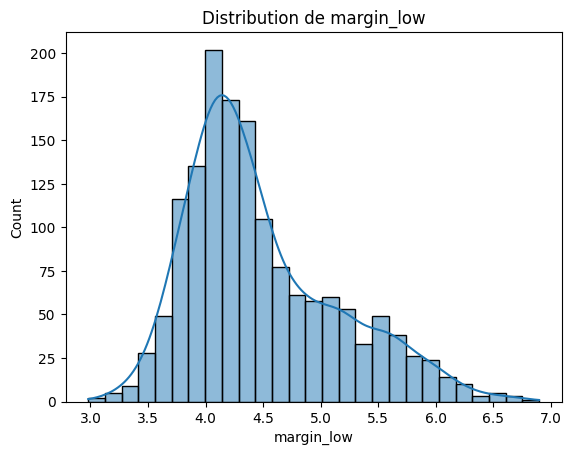

In [472]:
# On vérifie que la distribution de margin_low n'a pas bougé
sns.histplot(df_billet_clean['margin_low'].dropna(), kde=True)
plt.title("Distribution de margin_low")
plt.show()

In [473]:
df_billet_clean[df_billet_clean['margin_low_was_missing'] == True]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,margin_low_was_missing
72,True,171.94,103.89,103.45,4.323133,3.25,112.79,True
99,True,171.93,104.07,104.18,4.393907,3.14,113.08,True
151,True,172.07,103.80,104.38,4.416845,3.02,112.93,True
197,True,171.45,103.66,103.80,4.337374,3.62,113.27,True
241,True,171.83,104.14,104.06,4.634614,3.02,112.36,True
251,True,171.80,103.26,102.82,3.815222,2.95,113.22,True
284,True,171.92,103.83,103.76,4.190862,3.23,113.29,True
334,True,171.85,103.70,103.96,4.133982,3.00,113.36,True
410,True,172.56,103.72,103.51,4.156725,3.12,112.95,True
413,True,172.30,103.66,103.50,4.179140,3.16,112.95,True


In [474]:
df_billet_clean= df_billet_clean.drop(columns=['margin_low_was_missing'])

# Régression logistique

## Préparation

In [475]:
from sklearn.linear_model import LogisticRegression

# Séléction des prédicteurs pertinent et de la cible (is_genuine vrai/faux)
# Cible = 1 si vrai billet, 0 si faux
X = df_billet_clean.drop(columns=['is_genuine']) 
y = df_billet_clean['is_genuine']

# Découpage train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y # stratify garde le meme équilibre entre vrai et faux billet dans l'entrainement/test
)

## Entrainement

In [476]:
clf = LogisticRegression(random_state=42, max_iter=2000)
clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


## Test

In [477]:
# Extrait la ligne comme un tableau NumPy 1D
observation_20 = X_test.iloc[20].values 

# Remodele en une matrice 2D (1 ligne, N colonnes)
observation_20_2d = observation_20.reshape(1, -1)

print("Prédiction billet 20:", clf.predict(observation_20_2d))
print("Probabilités billet 20:", clf.predict_proba(observation_20_2d))

Prédiction billet 20: [False]
Probabilités billet 20: [[0.99835794 0.00164206]]


c:\Users\Pimi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
c:\Users\Pimi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


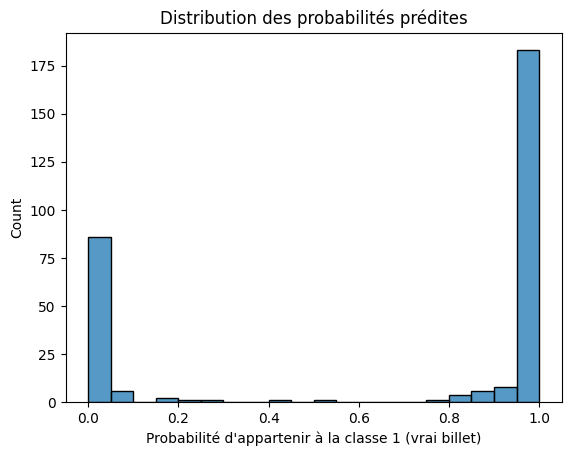

In [478]:
# Histogramme des probabilités
y_hat_proba = clf.predict_proba(X_test)[:, 1]  # proba d’être "vrai billet"
sns.histplot(y_hat_proba, bins=20, kde=False)
plt.xlabel("Probabilité d'appartenir à la classe 1 (vrai billet)")
plt.title("Distribution des probabilités prédites")
plt.show()

## Performance du modèle

In [479]:
## Exactitude (ou accuracy)

from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
print("Exactitude (accuracy) :", accuracy_score(y_test, y_pred))

Exactitude (accuracy) : 0.99


In [480]:
## Matrice de confusion
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

[[ 97   3]
 [  0 200]]


In [481]:
# Classe positive = False (faux billet)
precision_false = precision_score(y_test, y_pred, pos_label=False) # scikit-learn considère la classe positive = 1 (ou True). L'objectif est de détecter les faux billets 
recall_false    = recall_score(y_test, y_pred, pos_label=False)    # Avec pos_label=False, on voit combien de faux billets sont bien détectés et combien de vrais billets ont été faussement classés comme faux.

print("Précision (faux billets) :", precision_false)
print("Rappel (faux billets)   :", recall_false)

Précision (faux billets) : 1.0
Rappel (faux billets)   : 0.97


Précision = 1.0
Parmi tous les billets que le modèle a prédits comme faux billets, tous sont réellement des faux billets.
Aucun vrai billet n’a été classé à tort comme faux billet (aucun FP pour cette classe).

Rappel = 0.97
Parmi tous les vrais faux billets présents dans le test, le modèle a correctement identifié 97 % d’entre eux.

In [482]:
print(y_test.value_counts())

is_genuine
True     200
False    100
Name: count, dtype: int64


In [483]:
print(clf.classes_)

[False  True]


In [484]:
## Impact en changeant de seuil
# Probabilités
y_hat_proba = clf.predict_proba(X_test)[:,1]


# Seuil 0.3
y_pred_03 = (y_hat_proba >= 0.3).astype(int)
print("Matrice confusion (seuil=0.3) :\n", confusion_matrix(y_test, y_pred_03))

# Seuil 0.7
y_pred_07 = (y_hat_proba >= 0.7).astype(int)
print("Matrice confusion (seuil=0.7) :\n", confusion_matrix(y_test, y_pred_07))

Matrice confusion (seuil=0.3) :
 [[ 96   4]
 [  0 200]]
Matrice confusion (seuil=0.7) :
 [[ 97   3]
 [  1 199]]


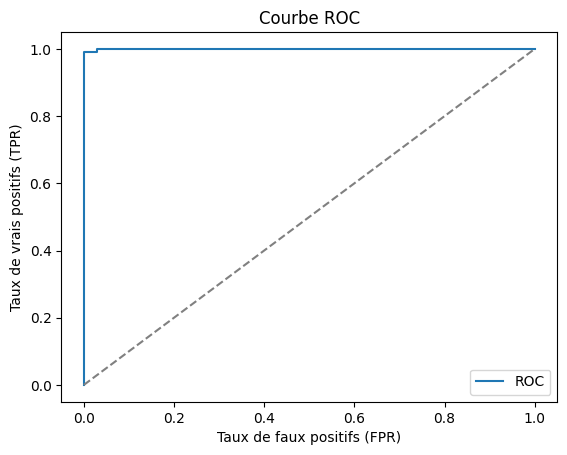

ROC-AUC : 0.9996999999999999


In [485]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_hat_proba)
plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC")
plt.legend()
plt.show()

print("ROC-AUC :", roc_auc_score(y_test, y_hat_proba))

On a un roc-auc de 99,96% ce qui valide notre modèle

matrice de confusion et accuracy de k-means (écrire la formule)
KNN : nuage de point on prend un point k = 3 (nb d'impair) on prend un billet (x) et je regarde les 3 billets les plus proche de x et sur les 3, 2 billets = vrai et 1 billet est faux donc on conclue que x est un vrai billet (juge les personnes selon leur voisin) -->
randomForrest = Akinator arbre de décision et la majorité décide

# KNN

In [486]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.model_selection import KNeighborsClassifier
# --- 1. SÉPARATION DES DONNÉES EN TRAIN ET TEST ---

Xknn = df_billet_clean.drop(columns=['is_genuine'])
yknn = df_billet_clean['is_genuine']

Xknn_train, Xknn_test, yknn_train, yknn_test = train_test_split(
    Xknn, 
    yknn, 
    test_size=0.2, 
    random_state=42, 
    # stratify est essentiel pour maintenir la proportion de classes (faux/vrai billet)
    stratify=yknn
)

# --- 2. DÉFINITION DU MODÈLE ET DE LA GRILLE ---

# Instanciation de StratifiedKFold
cv_stratified = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #n_splits = nb de plie --> cv=5 :

# L'ensemble de données d'entraînement (Xknn_train) est divisé en 5 sous-ensembles (ou "plis") de taille égale.
# L'algorithme entraîne le modèle 5 fois (une fois pour chaque combinaison d'hyperparamètres testée).
# À chaque itération, l'algorithme utilise 4 plis pour l'entraînement et le pli restant pour la validation (l'évaluation).
# Le score final pour une combinaison de paramètres est la moyenne des 5 scores de validation.

pipe_knn = Pipeline([
   ## ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier())
])

param_grid_knn = {
    'clf__n_neighbors': [3,5,7,9],
    'clf__weights': ['uniform', 'distance'],
    'clf__p': [1,2]  # p=1 manhattan, p=2 euclid
}
# 3 méthodes pour l'optimisation des hyperparamétres :
# parcours toutes les combinaisons sur toute les données (à vérifier) et prend la meilleurs --> GridSearch
# parcours toutes les combinaisons sur un échantillon et prend la meilleurs --> RandomSearch
# parcours les meilleurs combinaisons sur toutes les données --> Optuna
# --- 3. RECHERCHE PAR GRILLE ET ENTRAÎNEMENT --- Validation croisée
gs_knn = GridSearchCV(
    estimator=pipe_knn, 
    param_grid=param_grid_knn, 
    cv=cv_stratified, # Utilisation de l'instance StratifiedKFold
    scoring='recall',
    n_jobs=-1
)

# Entraînement du GridSearchCV uniquement sur les données d'ENTRAÎNEMENT
gs_knn.fit(Xknn_train, yknn_train)

# --- 4. AFFICHAGE DES RÉSULTATS ---
print(f"Meilleurs hyperparamètres trouvés : {gs_knn.best_params_}")
print(f"Meilleur score de rappel (sur la validation croisée) : {gs_knn.best_score_:.4f}")

Meilleurs hyperparamètres trouvés : {'clf__n_neighbors': 9, 'clf__p': 2, 'clf__weights': 'uniform'}
Meilleur score de rappel (sur la validation croisée) : 0.9963


In [487]:
# Utilisation de l'objet gs_knn pour faire des prédictions sur l'ensemble de test
yknn_pred = gs_knn.predict(Xknn_test)

In [488]:
# Calcule la matrice de confusion en comparant le réel et le prédit
cm = confusion_matrix(yknn_test, yknn_pred)

print("Matrice de Confusion:")
print(cm)

Matrice de Confusion:
[[ 97   3]
 [  0 200]]


In [489]:
precision_false = precision_score(yknn_test, yknn_pred, pos_label=False)
recall_false    = recall_score(yknn_test, yknn_pred, pos_label=False)

print("Précision (faux billets) :", precision_false)
print("Rappel (faux billets)   :", recall_false)

Précision (faux billets) : 1.0
Rappel (faux billets)   : 0.97


In [490]:
print(yknn.value_counts())

is_genuine
True     1000
False     500
Name: count, dtype: int64


In [491]:
yknn_proba = gs_knn.predict_proba(Xknn_test)[:, 1]  # Probabilité d’appartenance à la classe positive


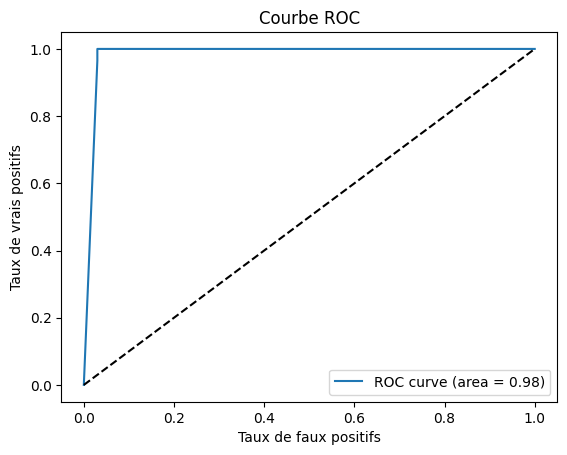

ROC-AUC KNN : 0.984475


In [492]:

fpr, tpr, thresholds = roc_curve(yknn_test, yknn_proba)
auc = roc_auc_score(yknn_test, yknn_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonale chance
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()
roc_auc = roc_auc_score(yknn_test, yknn_proba)
print("ROC-AUC KNN :", roc_auc)

La performance du modéle KNN est moins bonne que celle de la régression logistique

# Random Forest

In [493]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, recall_score


# Renommage des variables pour Random Forest (X_forest, y_forest)
X_forest = df_billet_clean.drop(columns=['is_genuine'])
y_forest = df_billet_clean['is_genuine']

# Séparation des données en ensembles d'entraînement et de test
X_forest_train, X_forest_test, y_forest_train, y_forest_test = train_test_split(
    X_forest, 
    y_forest, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_forest 
)

In [494]:
# Définition de la Validation Croisée Stratifiée (10 plis)
cv_stratified_forest = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

pipe_forest = Pipeline([
    # Le Standard Scaler est conservé par bonne pratique, bien que moins essentiel pour RF
    ##('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(random_state=42)) 
])

param_grid_forest = {
    'clf__n_estimators': [50, 100, 200],         # Nombre d'arbres
    'clf__max_depth': [5, 10, None],             # Profondeur maximale (None = pas de limite)
    'clf__min_samples_split': [2, 5],            # Échantillons minimum pour une division
    'clf__criterion': ['gini', 'entropy']        # Fonction de mesure de la qualité de la division
}

# Initialisation du GridSearchCV
gs_forest = GridSearchCV(
    estimator=pipe_forest, 
    param_grid=param_grid_forest, 
    cv=cv_stratified_forest, 
    scoring='recall', # On conserve le Rappel (Recall) comme métrique à maximiser
    n_jobs=-1         
)

In [495]:
# Entraînement du GridSearchCV uniquement sur les données d'ENTRAÎNEMENT
gs_forest.fit(X_forest_train, y_forest_train)

# Affichage des meilleurs hyperparamètres et du meilleur score de validation
print("\n--- Résultats GridSearchCV (Random Forest) ---")
print(f"Meilleurs hyperparamètres trouvés : {gs_forest.best_params_}")
print(f"Meilleur score de rappel (sur la validation croisée) : {gs_forest.best_score_:.4f}")


--- Résultats GridSearchCV (Random Forest) ---
Meilleurs hyperparamètres trouvés : {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__min_samples_split': 2, 'clf__n_estimators': 50}
Meilleur score de rappel (sur la validation croisée) : 0.9963


L’hyperparamètre criterion='entropy' indique que l’algorithme utilise le gain d’information pour les divisions, ce qui peut mieux convenir aux données que le critère Gini. Une profondeur maximale de 10 limite la complexité pour éviter le surapprentissage, ce qui est une bonne pratique.

Le nombre d’arbres à 50 est un compromis raisonnable entre performance et temps de calcul.

Le modèle est performant avec des paramètres optimisés.

In [496]:
# 1. Utilisation du meilleur estimateur pour prédire sur X_forest_test
y_forest_pred = gs_forest.predict(X_forest_test)

# 2. Calcul de la matrice de confusion
cm_forest = confusion_matrix(y_forest_test, y_forest_pred)
test_recall_forest = recall_score(y_forest_test, y_forest_pred)

precision_false = precision_score(y_forest_test, y_forest_pred, pos_label=False)
recall_false = recall_score(y_forest_test, y_forest_pred, pos_label=False)


print("\n--- Évaluation Finale (Random Forest) sur l'Ensemble de Test ---")
print(f"Matrice de Confusion:\n{cm_forest}")
print("Précision (faux billet) :", precision_false)
print("Rappel (faux billet) :", recall_false)


--- Évaluation Finale (Random Forest) sur l'Ensemble de Test ---
Matrice de Confusion:
[[ 97   3]
 [  0 200]]
Précision (faux billet) : 1.0
Rappel (faux billet) : 0.97



Rappel (~0.97) : → Le modèle détecte 97 % des faux billets (3 faux billets réels ont été classés à tort comme vrais).

Précision (= 1.0) : Tous les billets prédits comme « faux » sont effectivement des faux. Aucun faux positif.


In [497]:
y_forest_proba = gs_forest.predict_proba(X_forest_test)[:, 1]

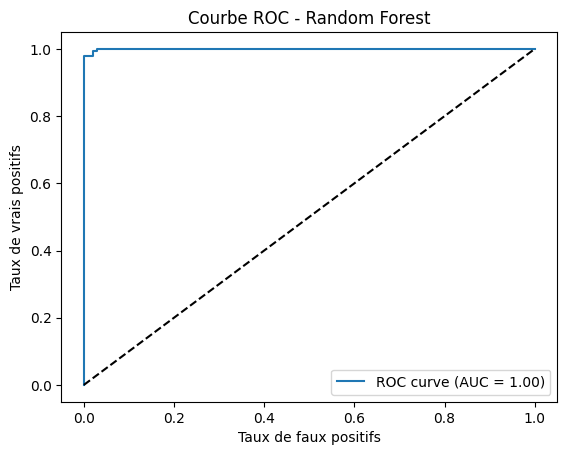

ROC-AUC Random Forest : 0.9995499999999999


In [498]:
fpr, tpr, thresholds = roc_curve(y_forest_test, y_forest_proba)
auc = roc_auc_score(y_forest_test, y_forest_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - Random Forest')
plt.legend(loc='lower right')
plt.show()

# Calcul ROC-AUC
auc = roc_auc_score(y_forest_test, y_forest_proba)
print("ROC-AUC Random Forest :", auc)

Le modèle Random Forest est plus performant que le KNN et similaire à celui de la Regression logistique

# K-Means

dessiner la methode du coude + silhouette
appliquer l'algorythme sur les 1500 billets sans faire de train/test
ajouter la colonne cluster et faire 1 count de 
faire la matrice de confusion à la main sous cette forme :
cm_forest = confusion_matrix(y_forest_test = is_genuine , y_forest_pred = cluster)
a partir de la matrice on calcule la précision et le rappel de la meme façon on remplace les y par genuine/cluster :
test_recall_forest = recall_score(y_forest_test, y_forest_pred)

Une fois le modèle selectionner :
utiliser la fonction pickle pour conserver le modèle et le mettre dans l'application
utiliser streamlit : mini framework de prototypage, ça permet de créer en python une interface graphique (petite application) 

In [499]:
df_billet_clean.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


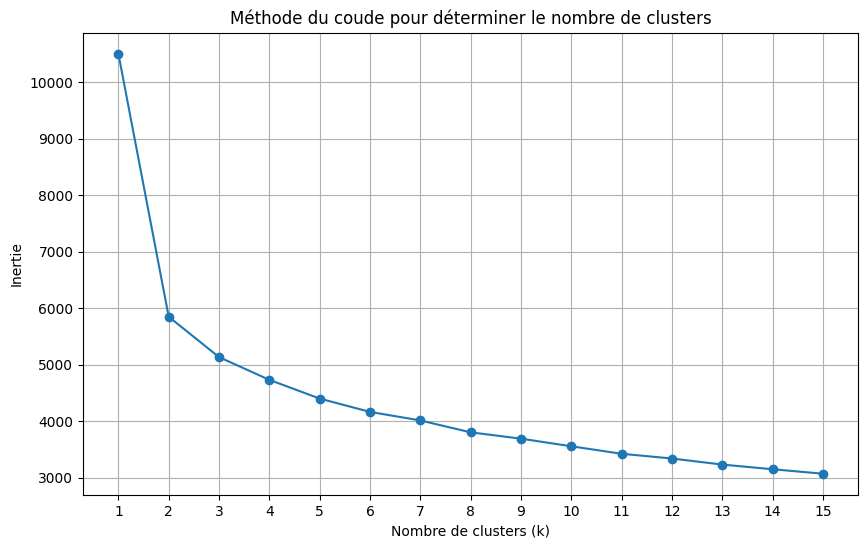

In [500]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


# 1. Normalisation des données
# scaler = StandardScaler()
# df_billet_clean_scaled = scaler.fit_transform(df_billet_clean)

# Calculez l'inertie pour un nombre de clusters de 1 à 15
inertias = []
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k, init = 'k-means++', random_state=12)
    kmeans.fit(df_billet_clean_scaled)
    inertias.append(kmeans.inertia_)

# Affichez le graphique de la méthode du coude
plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), inertias, marker='o')
plt.title('Méthode du coude pour déterminer le nombre de clusters')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.xticks(range(1, 16))
plt.grid(True)
plt.show()



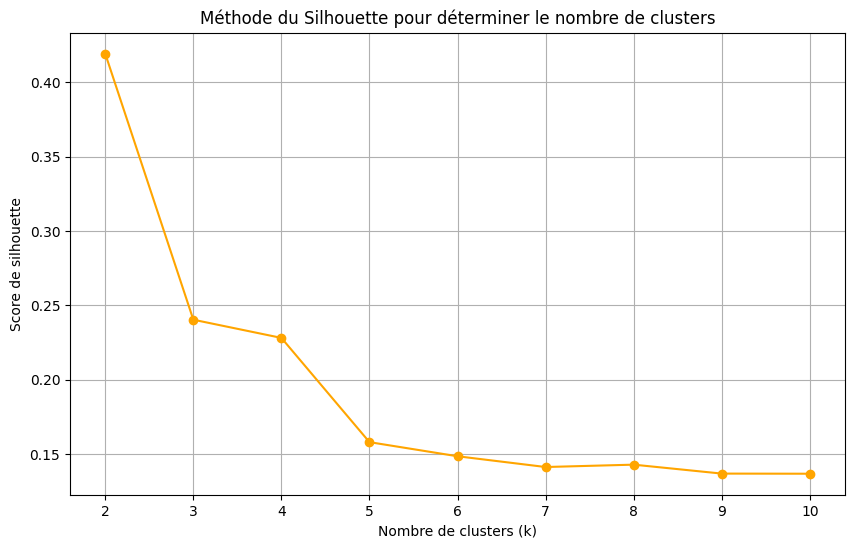

In [501]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
K = range(2, 11)  # le score de silhouette n’est pas défini pour k=1

for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=12)
    kmeans.fit(df_billet_clean_scaled)
    score = silhouette_score(df_billet_clean_scaled, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, marker='o', color='orange')
plt.title('Méthode du Silhouette pour déterminer le nombre de clusters')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score de silhouette')
plt.grid(True)
plt.show()

In [502]:
k_optimal = 2  
kmeans_final = KMeans(n_clusters=k_optimal, init='k-means++', random_state=18)
df_billet_clean['cluster'] = kmeans_final.fit_predict(df_billet_clean_scaled)

In [503]:
print(df_billet_clean['cluster'].value_counts())

cluster
1    1001
0     499
Name: count, dtype: int64


In [504]:
# K-Means

# Variables "réelles" et "prédites"
y_true = df_billet_clean['is_genuine']
y_pred = df_billet_clean['cluster']

# Matrice de confusion
matrice_kmean = confusion_matrix(y_pred, y_true, labels=[False, True])
print("Matrice de confusion :\n", matrice_kmean)

Matrice de confusion :
 [[498   1]
 [  2 999]]


Vrais négatifs (VN) = 498
→ 498 billets faux ont bien été classés dans le cluster “faux”.

Faux positifs (FP) = 2
→ Seulement 2 billets faux ont été mal classés comme vrais.

Faux négatifs (FN) = 1
→ 1 billet vrai a été mal classé comme faux.

Vrais positifs (VP) = 999
→ 999 billets vrais ont bien été classés dans le cluster “vrai”.


In [505]:
from sklearn.metrics import precision_score, recall_score

y_true = df_billet_clean['is_genuine']
y_pred = df_billet_clean['cluster']

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print("Précision :", precision)
print("Rappel :", recall)

Précision : 0.998001998001998
Rappel : 0.999


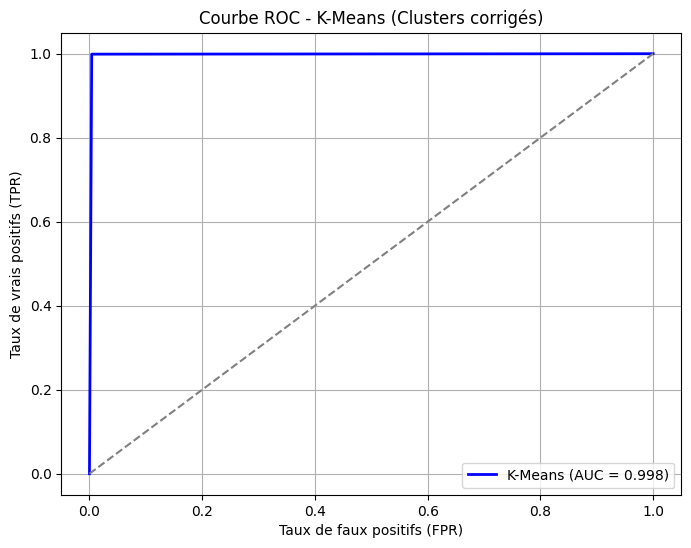

roc score: 0.9975


In [506]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Variables réelles et prédites
y_true = df_billet_clean['is_genuine']
y_pred = df_billet_clean['cluster']

# Calcul des points ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

# Tracé de la courbe ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'K-Means (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # ligne aléatoire
plt.title('Courbe ROC - K-Means (Clusters corrigés)')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("roc score:",auc_score)

# Synthèse
+ Regression logistique :
    - Précision : 1
    - Rappel : 0.9852216748768473
+ KNN :
    - Précision : 1
    - Rappel : 0.9852216748768473
+ Random Forest :
    - Précision : 1
    - Rappel : 0.9852216748768473
+ K-Means :
    - Précision : 0.998001998001998
    - Rappel : 0.999

Interprétation
Rappel (~0.97) : → Le modèle détecte 97 % des faux billets (3 faux billets réels ont été classés à tort comme vrais).

Précision (= 1.0) : Tous les billets prédits comme « faux » sont effectivement des faux. Aucun faux positif.


Les scores entres les differents algorithmes sont quasi identique.  Cela se produit car comme nous l'avons vu, les variables length, margin_low,  et margin_up sont très discriminante et chaque modèle a réussi très facilement à classifier les vrai des faux billets.
Nous avons une courbe ROC quasi parfaite sur chaque algorithme.

K-Means est un modèle non supervisé dont le but est de découvrir des structures dans des données non étiquetées. Il est donc moins adapté que la classification supervisée lorsque la variable cible (is_genuine) est déjà connue. Néanmoins, sa performance élevée confirme l'existence de deux groupes très distincts dans les données, ce qui soutient le diagnostic de séparabilité.

Nous choisissons le modèle de régression logistique pour sa simplicité et sa rapidité d'execution. D'autant qu'il obtient la meilleurs courbe ROC

# Sauvegarde du modèle : Régression logistique

In [507]:
import pickle
# Sauvegarde du modèle entraîné
with open("modele_logreg.pkl", "wb") as f:
    pickle.dump(clf, f)

print("✅ Modèle sauvegardé sous 'modele_logreg.pkl'")

✅ Modèle sauvegardé sous 'modele_logreg.pkl'
